# Visualizing melspectograms

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from librosa import display
import torch

## Original spectograms

### STFT

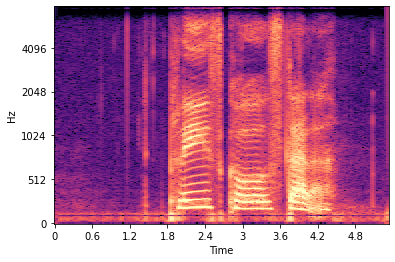

In [80]:
sub_org = 'p228'
sentence_org = '001' # OBS! all metadatafiles only contain first sentence.. we want to check conversion for different sentences to make to content encoder works

sub_trg = 'p227'
sentence_trg = '001' # OBS! all metadatafiles only contain first sentence.. we want to check conversion for different sentences to make to content encoder works

stft_org = np.load('/work3/dgro/VCTK-Corpus-0/stft/'+sub_org+'/'+sub_org+'_'+sentence_org+'_mic2.npy')
stft_trg = np.load('/work3/dgro/VCTK-Corpus-0/stft/'+sub_trg+'/'+sub_trg+'_'+sentence_trg+'_mic2.npy')

# STFT
display.specshow(
    stft_org.T * 100 - 100,
    y_axis="fft",
    x_axis="time",
    fmin=90,
    fmax=7_600, 
    sr=16_000,
)
plt.savefig('stftorg_'+sub_org+'_'+sentence_org+'.pdf')

display.specshow(
    stft_org.T * 100 - 100,
    y_axis="mel",
    x_axis="time",
    fmin=90,
    fmax=7_600, 
    sr=16_000,
)
plt.savefig('stfttrg_'+sub_trg+'_'+sentence_trg+'.pdf')

### Mel

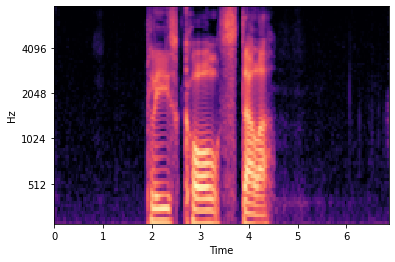

In [81]:
mel_org = np.load('/work3/dgro/VCTK-Corpus-0/spmel/'+sub_org+'/'+sub_org+'_'+sentence_org+'_mic2.npy')
mel_trg = np.load('/work3/dgro/VCTK-Corpus-0/spmel/'+sub_trg+'/'+sub_trg+'_'+sentence_trg+'_mic2.npy')

# MEL
display.specshow(
    mel_org.T * 100 - 100,
    y_axis="mel",
    x_axis="time",
    fmin=90,
    fmax=7_600, 
    sr=16_000,
)
plt.savefig('melorg_'+sub_org+'_'+sentence_org+'.pdf')

display.specshow(
    mel_trg.T * 100 - 100,
    y_axis="mel",
    x_axis="time",
    fmin=90,
    fmax=7_600, 
    sr=16_000,
)
plt.savefig('meltrg_'+sub_trg+'_'+sentence_trg+'.pdf')

## Converted spectograms

In [82]:
from model_vc_mel import Generator
from model_vc_stft import GeneratorSTFT
#from model_vc_wav import GeneratorWav

G_mel = Generator(32, 256, 512, 32)
G_stft = GeneratorSTFT(32, 256, 512, 32)
#G_wav1 = GeneratorWav(32, 256, 512, 32, 1)
#G_wav3 = GeneratorWav(32, 256, 512, 32, 3)
#G_wav5 = GeneratorWav(32, 256, 512, 32, 5)

checkpoint_mel = torch.load('chkpnt_spmel_reproducedAutoVC_new_22April23_1444_43_resumed_resumed_resumed_resumed.ckpt',map_location=torch.device('cpu'))
checkpoint_stft = torch.load('chkpnt_stft_stft_scratch_22April21_1408_13_resumed_resumed.ckpt',map_location=torch.device('cpu'))
#checkpoint_wav1 = 
#checkpoint_wav3 =
#checkpoint_wav5 =  

G_mel.load_state_dict(checkpoint_mel['state_dict'])
G_stft.load_state_dict(checkpoint_stft['state_dict'])
#G_wav1.load_state_dict(checkpoint_wav1['state_dict'])
#G_wav3.load_state_dict(checkpoint_wav3['state_dict'])
#G_wav5.load_state_dict(checkpoint_wav5['state_dict'])

<All keys matched successfully>

#### Load metadata 

In [83]:
metadata_mel = pickle.load(open('/work3/dgro/VCTK-Corpus-0/spmel/metadata.pkl', "rb"))
metadata_stft = pickle.load(open('/work3/dgro/VCTK-Corpus-0/stft_metadata.pkl', "rb"))

In [84]:
len(metadata_mel), len(metadata_stft)

(96, 96)

In [99]:
#print(np.array(metadata_stft[5])[0]), print(np.array(metadata_stft[4])[0])

org = 5 # p228
trg = 4 # p227

uttr_org_stft = metadata_stft[org][2]
uttr_trg_stft = metadata_stft[trg][2]
emb_org_stft = metadata_stft[org][1]
emb_trg_stft = metadata_stft[trg][1]

uttr_org_mel = metadata_mel[org][2]
uttr_trg_mel= metadata_mel[trg][2]
emb_org_mel = metadata_mel[org][1]
emb_trg_mel = metadata_mel[trg][1]

In [108]:
# conversion: G(uttr_org, emb_org, emb_trg)
# training: G(x_real, emb_org, emb_org)
len_pad = 128

_, x_identic_psnt, _ = G_mel(uttr_org_mel, emb_org_mel, emb_trg_mel)
uttr_trg_mel = x_identic_psnt[0, :-len_pad, :]


_, x_identic_psnt, _ = G_stft(uttr_org_stft, emb_org_stft, emb_trg_stft)
uttr_trg_stft = x_identic_psnt[0, :-len_pad, :]

#_, _, gen_outputs, _ = G_wav(uttr_org_wav, emb_org_wav, emb_org_wav)


X shape
(167, 80)


ValueError: cannot select an axis to squeeze out which has size not equal to one